# Objetivo:

    Utilizando os dados tratados anteriormoente, desenvolver um modelo de classificação que seja eficiente para identificar quando o empréstimo for de risco ou não.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url='https://raw.githubusercontent.com/robertferro/analisando_risco_credito/main/1-%20Tratamento%20de%20dados%20(ETL)/dados_analise_risco_de_cresdito.csv'

In [3]:
df = pd.read_csv(url,sep=',')

In [4]:
df.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,tipo_moradia_id,objetivo_emprestimo_id,class_risco_historico_id
0,21,5.0,propria,educacao,1000,11.14,9600,0.10,B,0,2,0,3,1,1
1,25,1.0,hipoteca,saude,5500,12.87,9600,0.57,C,0,3,1,1,5,2
2,23,4.0,alugada,saude,35000,15.23,65500,0.53,C,0,2,1,0,5,2
3,24,8.0,alugada,saude,35000,14.27,54400,0.55,C,1,4,1,0,5,2
4,21,2.0,propria,risco,2500,7.14,9900,0.25,A,0,2,1,3,4,0


# 4 - Machine learning

 - Pre-processamento dos dados

- Divisao treino e teste

In [5]:
dados_ml = df.drop(columns = ['tipo_moradia','objetivo_emprestimo','class_risco_historico'],axis=1)

In [7]:
X = dados_ml.drop('risco_emprestimo',axis=1)
Y = dados_ml['risco_emprestimo']

In [8]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier()

_ = clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

# features[ features.importancia > np.mean(features.importancia)].sort_values(by='importancia',ascending=False)


In [9]:
features.sort_values(by='importancia',ascending=False)

,feature,importancia
5,porc_empr_renda_anual,0.224345
10,class_risco_historico_id,0.128723
4,renda_por_ano,0.112808
3,taxa_juros,0.104108
2,montante_emprestimo,0.081827
8,tipo_moradia_id,0.079438
9,objetivo_emprestimo_id,0.074756
1,tempo_de_emprego,0.070974
0,idade,0.055946
7,qtd_anos_primeiro_emprestimo,0.048087


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,Y, test_size=0.2,stratify=Y)

- Benchmark

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_treino, Y_treino)
y_pred = dummy_clf.predict(X_teste)
acuracia = dummy_clf.score(X_teste, Y_teste) * 100

print('A acurácia do dummy mostfrequent foi %.2f%%' % acuracia)

A acurácia do dummy mostfrequent foi 78.46%


Text(33.0, 0.5, 'Real ( 1 ou 0)')

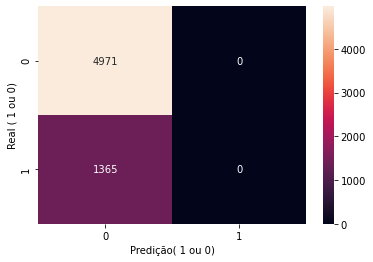

In [14]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

In [15]:
from sklearn.metrics import  roc_auc_score,roc_curve, classification_report
from sklearn import metrics

y_proba = dummy_clf.predict_proba(X_teste)
roc_auc_score(Y_teste, y_proba[:,1])

0.5

In [16]:
print(classification_report(Y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4971
           1       0.00      0.00      0.00      1365

    accuracy                           0.78      6336
   macro avg       0.39      0.50      0.44      6336
weighted avg       0.62      0.78      0.69      6336



- Testando alguns modelos e fazendo também a validação cruzada.

In [17]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.model_selection import cross_val_score

lista_classificacores = [ LogisticRegression(),
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier(),
                         XGBClassifier()]


for clf in lista_classificacores:
  print(clf.__class__.__name__)
  clf.fit(X_treino, Y_treino)
  train_acc = clf.score(X_treino, Y_treino)
  val_score = cross_val_score(clf, X_treino, Y_treino, cv=5)
  test_acc = clf.score(X_teste, Y_teste)
  print('Treino:', train_acc)
  print('Validation score', val_score.mean())
  print('Teste:', test_acc)

  print('ROC AUC')

  y_proba_treino = clf.predict_proba(X_treino)
  roc_treino = roc_auc_score(Y_treino, y_proba_treino[:, 1])
  print('Treino', roc_treino)

  y_proba_teste = clf.predict_proba(X_teste)
  roc_teste = roc_auc_score(Y_teste, y_proba_teste[:, 1])
  print('Test', roc_teste)
  print('='*80)

LogisticRegression
Treino: 0.8079154007023636
Validation score 0.807875983877113
Teste: 0.8077651515151515
ROC AUC
Treino 0.7597253088074393
Test 0.7594602540891014
GaussianNB
Treino: 0.8246458588170303
Validation score 0.8247641972507884
Teste: 0.8202335858585859
ROC AUC
Treino 0.7838699800425899
Test 0.7734439234740985
DecisionTreeClassifier
Treino: 1.0
Validation score 0.8881348129825769
Teste: 0.8871527777777778
ROC AUC
Treino 1.0
Test 0.8403962764252445
RandomForestClassifier
Treino: 0.9999210827447421
Validation score 0.9332359375892867
Teste: 0.931344696969697
ROC AUC
Treino 1.0
Test 0.9285563226420197
XGBClassifier
[19:15:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:15:40] WARNING: C:/Users/Administrator/workspace/xgboos

In [18]:
clf = XGBClassifier(max_depth=15,n_estimators=250,seed=42)

In [19]:
clf.fit(X_treino, Y_treino)

[19:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=2, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [20]:
y_pred = clf.predict(X_teste)
acuracia = clf.score(X_teste, Y_teste) * 100

print('A acurácia do XGBCLassifier foi %.2f%%' % acuracia)

A acurácia do XGBCLassifier foi 93.70%


Text(33.0, 0.5, 'Real ( 1 ou 0)')

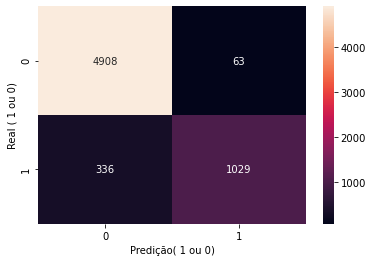

In [21]:
cm=confusion_matrix(Y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

In [22]:
y_proba = clf.predict_proba(X_teste)[:,1]
roc_auc = roc_auc_score(Y_teste, y_proba)
roc_auc

0.9478286884442587

In [23]:
print(classification_report(Y_teste, y_proba>0.5))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4971
           1       0.94      0.75      0.84      1365

    accuracy                           0.94      6336
   macro avg       0.94      0.87      0.90      6336
weighted avg       0.94      0.94      0.93      6336



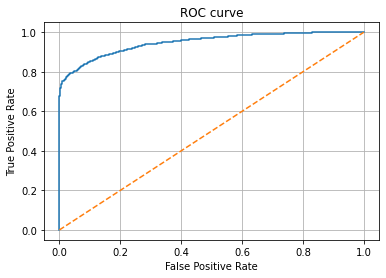

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(Y_teste,y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()